In [66]:
from BO_model import BayesianOptimization
import pandas as pd 
from botorch.test_functions import Ackley
from botorch.test_functions import Levy 
from botorch.test_functions import Beale
from botorch.test_functions import DixonPrice
from botorch.test_functions import DropWave
from botorch.test_functions import Hartmann
from botorch.test_functions import StyblinskiTang
# Variables that determine the size of the dataset
N_INITIAL = 20
EPOCHS = 50
BATCH_SIZE = 10
DIM = 2
LOWER = -32.768
UPPER = 32.768

optimizer = BayesianOptimization(fun=Ackley(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=5,
                                 acqf_type='qUCB')

x_max, y_max, model = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)
y1 = full['y']
mean_y1 = y1.mean()
std_y1 = y1.std()
min_y1 = y1.min()
max_y1 = y1.max()
print(mean_y1,std_y1)

,Batch,x1,x2,y
0,0.0,-1.291680,-25.083322,-20.790246
1,0.0,29.477328,15.926574,-21.589321
2,0.0,9.202754,-11.321871,-19.247196
3,0.0,-21.980248,29.684117,-21.267342
4,0.0,-30.283613,-7.202564,-21.430370
...,...,...,...,...
515,50.0,19.801944,6.777125,-20.404024
516,50.0,0.178272,0.142561,-1.654226
517,50.0,2.846467,3.881279,-10.673394
518,50.0,19.156490,24.248747,-21.140752


-18.579341401834057 5.545315577398223


/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_1954/884754453.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_values_x1 = ackley(torch.tensor(scale_back(test_points_tensor_x1, x_min, x_max)))
/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_1954/884754453.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_values_x2 = ackley(torch.tensor(scale_back(test_points_tensor_x2, x_min, x_max)))


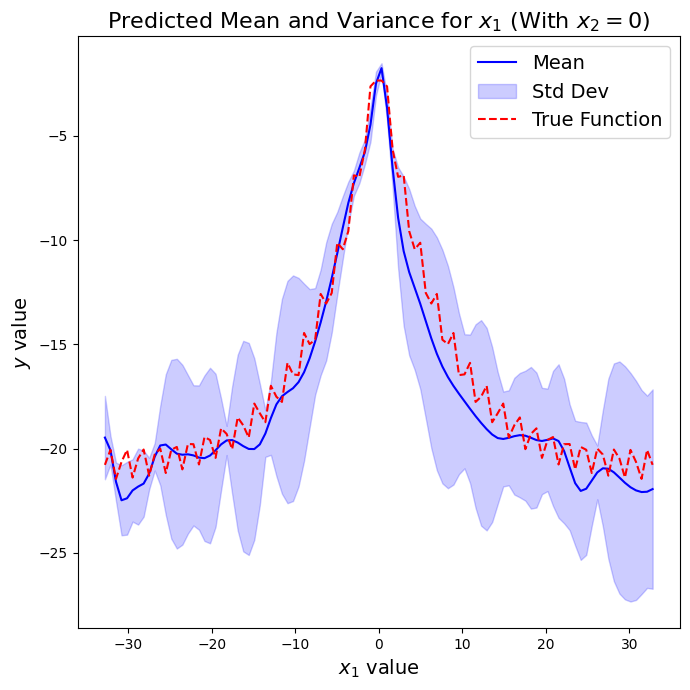

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from botorch.test_functions import Ackley

x_min = LOWER
x_max = UPPER
ackley = Ackley(dim=2, negate=True)

# Function to scale values to [0, 1]
def scale_to_01(values, min_val, max_val):
    return (values - min_val) / (max_val - min_val)

def scale_back(values, min_val, max_val):
    return values * (max_val - min_val) + min_val

def denormalize(y_normalized, mean_y, std_y):
    return y_normalized * std_y + mean_y

def denormalize_std(std_normalized, min_val, max_val):
    scale_factor = max_val - min_val

    return std_normalized * scale_factor

x1_test_points_orig = np.linspace(x_min, x_max, 100)
x2_fixed_orig = np.ones_like(x1_test_points_orig)*0.5

# Scale test points to [0, 1]
x1_test_points = scale_to_01(x1_test_points_orig, x_min, x_max)
x2_fixed = x2_fixed_orig
test_points_x1 = np.vstack([x1_test_points, x2_fixed]).T

x2_test_points_orig = np.linspace(x_min, x_max, 100)
x1_fixed_orig = np.ones_like(x2_test_points_orig)*0.5

x2_test_points = scale_to_01(x2_test_points_orig, x_min, x_max)
x1_fixed = x1_fixed_orig
test_points_x2 = np.vstack([x1_fixed, x2_test_points]).T

test_points_tensor_x1 = torch.tensor(test_points_x1, dtype=torch.float32)
test_points_tensor_x2 = torch.tensor(test_points_x2, dtype=torch.float32)

# Make predictions for x1 while fixing x2
model.eval()
with torch.no_grad():
    predictions_x1 = model(test_points_tensor_x1)
    mean_x1 = predictions_x1.mean.detach().numpy()
    variance_x1 = predictions_x1.variance.detach().numpy()
    std_x1 = np.sqrt(variance_x1)

# Make predictions for x2 while fixing x1
with torch.no_grad():
    predictions_x2 = model(test_points_tensor_x2)
    mean_x2 = predictions_x2.mean.detach().numpy()
    variance_x2 = predictions_x2.variance.detach().numpy()
    std_x2 = np.sqrt(variance_x2)

# Rescale
x1_test_points_orig = scale_back(x1_test_points, x_min, x_max)
x2_test_points_orig = scale_back(x2_test_points, x_min, x_max)

std_x1 = denormalize_std(std_x1, min_y1, max_y1)
std_x2 = denormalize_std(std_x2, min_y1, max_y1)

mean_x2 = denormalize(mean_x2, mean_y1, std_y1)
mean_x1 = denormalize(mean_x1, mean_y1, std_y1)

true_values_x1 = ackley(torch.tensor(scale_back(test_points_tensor_x1, x_min, x_max)))
true_values_x2 = ackley(torch.tensor(scale_back(test_points_tensor_x2, x_min, x_max)))


plt.figure(figsize=(7, 7))

# plt.subplot(1, 2, 1)
plt.plot(x1_test_points_orig, mean_x1, 'b-', label='Mean')
plt.fill_between(x1_test_points_orig, mean_x1 - std_x1, mean_x1 + std_x1, color='b', alpha=0.2, label='Std Dev')
plt.plot(x1_test_points_orig, true_values_x1.numpy(), 'r--', label='True Function')
plt.title('Predicted Mean and Variance for $x_1$ (With $x_2=0$)', fontsize=16)
plt.xlabel('$x_1$ value', fontsize=14)
plt.ylabel('$y$ value', fontsize=14)
plt.legend(fontsize=14)

# Plot for x2 while fixing x1
#plt.subplot(1, 2, 2)
#plt.plot(x2_test_points_orig, mean_x2, 'b-', label='Mean')
#plt.fill_between(x2_test_points_orig, mean_x2 - std_x2, mean_x2 + std_x2, color='b', alpha=0.2, label='Std Dev')
#plt.plot(x1_test_points_orig, true_values_x1.numpy(), 'r--', label='True Function')
# plt.title('Predicted Mean and Variance for $x_2$ (With $x_1=0$)')
# plt.xlabel('$x_2$')
# plt.ylabel('$y$')
# plt.legend()

plt.tight_layout()
plt.show()

In [136]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from botorch.test_functions import Ackley


grid_size = 1000 
x1_test_points_orig = np.linspace(x_min, x_max, grid_size)
x2_test_points_orig = np.linspace(x_min, x_max, grid_size)
x1_grid, x2_grid = np.meshgrid(x1_test_points_orig, x2_test_points_orig)

# Scale test points to [0, 1]
x1_grid_scaled = scale_to_01(x1_grid, x_min, x_max)
x2_grid_scaled = scale_to_01(x2_grid, x_min, x_max)

test_points_grid = np.stack([x1_grid_scaled.flatten(), x2_grid_scaled.flatten()], axis=1)
test_points_tensor_grid = torch.tensor(test_points_grid, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    predictions_grid = model(test_points_tensor_grid)
    mean_grid = predictions_grid.mean.detach().numpy()

# Rescale mean_grid back to the original scale
mean_grid_rescaled = denormalize(mean_grid, mean_y1, std_y1)  # Replace mean_y1 and std_y1 with your actual normalization values


mean_grid_rescaled = mean_grid_rescaled.reshape(x1_grid.shape)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_test_points_orig, x2_test_points_orig, mean_grid_rescaled, levels=15, cmap='Blues')
plt.colorbar(contour, label='Predicted Mean')

# Plotting the maximum point at [0, 0]
plt.plot([0], [0], 'wo', markersize=3)

plt.title('Predicted Mean for $x_1$ vs $x_2$', fontsize=16)
plt.xlabel('$x_1$ value', fontsize=14)
plt.ylabel('$x_2$ value', fontsize=14)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 